In [1]:
import io
import os
import re
import sys
import time, datetime
import joblib
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from tqdm import tnrange
from IPython import display
from sklearn import model_selection, preprocessing

sys.path.append('%s/lib' % (os.path.abspath('..')))
from SyntheticLCGenerator import synthetic_light_curve_generator
from mmd import rbf_mmd2, median_pairwise_distance, mix_rbf_mmd2_and_ratio
#from Logger import Logger

import tensorflow as tf

In [2]:
main_path = os.path.abspath('..')
main_path

'/Users/jorgetil/Astro/TL-GANs'

# 2. GAN Model

### latent space functions

In [134]:
def sample_Z(batch_size, seq_length, latent_dim, 
             only_one=False, use_time=True, rnd_state=1):
    if only_one:
        sample = np.zeros((batch_size, seq_length, latent_dim))
        for i in range(len(sample)):
            sample[i,:,:] = np.random.normal(size=[latent_dim])
    else:
        sample = np.float32(np.random.normal(
            size=[batch_size, seq_length, latent_dim]))
        if use_time:
            ## set the first dimension of every sequence as the
            ## time using a sequence of "seq_length" between [0,1]
            sample[:, :, 0] = np.linspace(0., 1.0, num=seq_length)
    return sample


def sample_C(batch_size, cond_dim=0, max_val=1, one_hot=False):
    """
    return an array of integers (so far we only allow integer-valued
    conditional values)
    """
    if cond_dim == 0:
        return None
    else:
        if one_hot:
            assert max_val == 1
            C = np.zeros(shape=(batch_size, cond_dim))
            # locations
            labels = np.random.choice(cond_dim, batch_size)
            C[np.arange(batch_size), labels] = 1
        else:
            C = np.random.choice(max_val+1, size=(batch_size, cond_dim))
        return C

### training functions

In [135]:
def GAN_loss(Z, X, generator_settings, discriminator_settings,
             cond, CG, CD, CS, wrong_labels=False, smooth_labels=False):
    '''
    GAN loss function
    '''
    if cond:
        # C-GAN
        G_sample = generator(Z, **generator_settings, c=CG)
        D_real, D_logit_real = discriminator(X, **discriminator_settings,
                                             c=CD)
        D_fake, D_logit_fake = discriminator(G_sample, reuse=True,
                                             **discriminator_settings, c=CG)

        if wrong_labels:
            # the discriminator must distinguish between real data
            # with fake labels and real data with real labels, too
            D_wrong, D_logit_wrong = discriminator(X, reuse=True,
                                                   **discriminator_settings,
                                                   c=CS)
    else:
        # normal GAN
        G_sample = generator(Z, **generator_settings)
        D_real, D_logit_real = discriminator(X, **discriminator_settings)
        D_fake, D_logit_fake = discriminator(G_sample, reuse=True,
                                             **discriminator_settings)

    ## Discriminator loss
    with tf.name_scope('Loss_D'):
        # smooth labels during Discriminator training
        if smooth_labels:
            label_real = tf.random.uniform(D_logit_real.shape, minval=.9, maxval=1)
            label_fake = tf.random.uniform(D_logit_fake.shape, minval=0., maxval=.1)
        else:
            label_real = tf.ones_like(D_logit_real)
            label_fake = tf.zeros_like(D_logit_fake)
        tf.summary.histogram('Ones', label_real)
        tf.summary.histogram('Zeros', label_fake)

        D_loss_real = tf.reduce_mean(tf.nn.sigmoid_cross_entropy_with_logits(
            logits=D_logit_real, labels=label_real), 1)
        D_loss_fake = tf.reduce_mean(tf.nn.sigmoid_cross_entropy_with_logits(
            logits=D_logit_fake, labels=label_fake), 1)
        D_loss = D_loss_real + D_loss_fake
        if cond and wrong_labels:
            D_loss = D_loss + D_loss_wrong
        D_loss = tf.reduce_mean(D_loss)
    
    with tf.name_scope('Acc_D'):
        ## Discriminator Acc
        D_acc = tf.equal(tf.argmax(tf.stack([D_logit_real, D_logit_fake]), 1), 
                         tf.argmax(tf.stack([label_real, label_fake]), 1))
        D_acc = tf.reduce_mean(tf.cast(D_acc, tf.float32))

    with tf.name_scope('Loss_G'):
        ## Generator loss
        G_loss = tf.reduce_mean(tf.nn.sigmoid_cross_entropy_with_logits(
            logits=D_logit_fake, labels=tf.ones_like(D_logit_fake)), 1)
        G_loss = tf.reduce_mean(G_loss)

    return D_loss, G_loss, D_acc


def GAN_solvers(D_loss, G_loss, learning_rate):
    """
    Optimizers
    """
    discriminator_vars = [v for v in tf.trainable_variables()
                          if v.name.startswith('discriminator')]
    generator_vars = [v for v in tf.trainable_variables()
                      if v.name.startswith('generator')]

    with tf.name_scope('Adam_D'):
        D_solver = tf.train.AdamOptimizer(learning_rate=learning_rate).minimize(
            D_loss, var_list=discriminator_vars)

    with tf.name_scope('Adam_G'):
        G_solver = tf.train.AdamOptimizer(learning_rate=learning_rate).minimize(
            G_loss, var_list=generator_vars)
    
    return D_solver, G_solver

### model functions

In [136]:
def create_placeholders(batch_size, seq_length, latent_dim,
                        n_feat, cond_dim):
    Z = tf.placeholder(tf.float32, [batch_size, seq_length, 
                                    latent_dim],
                       name='Z')
    X = tf.placeholder(tf.float32, [batch_size, seq_length, 
                                    n_feat],
                      name='X')
    CG = tf.placeholder(tf.float32, [batch_size, cond_dim],
                        name='CG')
    CD = tf.placeholder(tf.float32, [batch_size, cond_dim],
                        name='CD')
    CS = tf.placeholder(tf.float32, [batch_size, cond_dim],
                        name='CS')

    return Z, X, CG, CD, CS


def generator(z, hidden_units_g, seq_length, batch_size, n_feat,
              num_layers=1, reuse=False, parameters=None,
              cond_dim=0, c=None, dropout=0.):
    """
    If parameters are supplied, initialise as such
    """
    with tf.variable_scope("generator", reuse=False) as scope:
        if reuse:
            scope.reuse_variables()
        if parameters is None:
            W_out_G_initializer = tf.truncated_normal_initializer()
            b_out_G_initializer = tf.truncated_normal_initializer()
            lstm_initializer = None
            bias_start = 1.0
        else:
            W_out_G_initializer = tf.constant_initializer(
                value=parameters['generator/W_out_G:0'])
            b_out_G_initializer = tf.constant_initializer(
                value=parameters['generator/b_out_G:0'])
            lstm_initializer = tf.constant_initializer(
                value=parameters['generator/rnn/lstm_cell/weights:0'])
            bias_start = parameters['generator/rnn/lstm_cell/biases:0']
        
        W_out_G = tf.get_variable(name='W_out_G',
                                  shape=[hidden_units_g,
                                         n_feat],
                                  initializer=W_out_G_initializer)
        tf.summary.histogram('W_out_G', W_out_G)
        b_out_G = tf.get_variable(name='b_out_G',
                                  shape=n_feat,
                                  initializer=b_out_G_initializer)
        tf.summary.histogram('b_out_G', b_out_G)

        if cond_dim > 0:
            # CGAN!
            assert not c is None
            repeated_encoding = tf.stack([c]*seq_length, axis=1)
            inputs = tf.concat([z, repeated_encoding], axis=2)
        else:
            inputs = z

        fw_lstms = []
        for kk in range(num_layers):
            cell = tf.contrib.rnn.LSTMCell(num_units=hidden_units_g,
                                           state_is_tuple=True,
                                           initializer=lstm_initializer,
                                           reuse=reuse,
                                           name='LSTM_cell_%i' % (kk))
            if dropout > 0.:
                with tf.name_scope('drop_%i' % (kk)):
                    cell = tf.contrib.rnn.DropoutWrapper(cell, 
                                                         output_keep_prob=1 - dropout)
            fw_lstms.append(cell)
        fw_lstms = tf.contrib.rnn.MultiRNNCell(fw_lstms)
        rnn_outputs, rnn_states = tf.nn.dynamic_rnn(cell=fw_lstms,
                                                    dtype=tf.float32,
                                                    sequence_length=[
                                                        seq_length]*batch_size,
                                                    inputs=inputs)
        tf.summary.histogram('multiRNN', rnn_outputs)
        rnn_outputs_2d = tf.reshape(rnn_outputs, [-1, hidden_units_g], 
                                    name='2d_reshape')
        with tf.name_scope('Dense'):
            logits_2d = tf.matmul(rnn_outputs_2d, W_out_G) + b_out_G
            tf.summary.histogram('pre_activation', logits_2d)
        # logits_3d = tf.einsum('ijk,km', rnn_outputs, W_out_G) + b_out_G
        # output_2d = tf.nn.tanh(logits_2d, name='tanh_out')
        output_3d = tf.reshape(logits_2d,
                               [-1, seq_length, n_feat], 
                               name='3d_reshape')
    return output_3d


def discriminator(x, hidden_units_d, seq_length, batch_size, 
                  num_layers=1, reuse=False, dropout=0.,
                  cond_dim=0, c=None, batch_mean=False,
                  batch_norm=True):
    with tf.variable_scope("discriminator") as scope:
        if reuse:
            scope.reuse_variables()
        W_out_D = tf.get_variable(name='W_out_D', shape=[hidden_units_d, 1],
                                  initializer=tf.truncated_normal_initializer())
        tf.summary.histogram('W_out_D', W_out_D)
        b_out_D = tf.get_variable(name='b_out_D', shape=1,
                                  initializer=tf.truncated_normal_initializer())
        tf.summary.histogram('b_out_D', b_out_D)

        if cond_dim > 0:
            assert not c is None
            repeated_encoding = tf.stack([c]*seq_length, axis=1)
            inputs = tf.concat([x, repeated_encoding], axis=2)
        else:
            inputs = x

        if batch_norm:
            inputs = tf.layers.batch_normalization(inputs, axis=1, 
                                                   renorm=True, 
                                                   name='batch_norm')
            tf.summary.histogram('b_renorm', inputs)
        fw_lstms = []
        for kk in range(num_layers):
            cell = tf.contrib.rnn.LSTMCell(num_units=hidden_units_d,
                                           state_is_tuple=True,
                                           reuse=reuse,
                                           name='LSTM_cell_%i' % (kk))
            if dropout > 0.:
                with tf.name_scope('drop_%i' % (kk)):
                    cell = tf.contrib.rnn.DropoutWrapper(cell, 
                                                         output_keep_prob=1 - dropout)
            fw_lstms.append(cell)
        fw_lstms = tf.contrib.rnn.MultiRNNCell(fw_lstms)
        rnn_outputs, rnn_states = tf.nn.dynamic_rnn(cell=fw_lstms,
                                                    dtype=tf.float32,
                                                    inputs=inputs)
        tf.summary.histogram('multiRNN', rnn_outputs)
        with tf.name_scope('Dense'):
            logits = tf.einsum('ijk,km', rnn_outputs, W_out_D) + b_out_D
            tf.summary.histogram('pre_activations', logits)
        output = tf.nn.sigmoid(logits, name='sigmoid_out')
        tf.summary.histogram('exit', output)

    return output, logits

### extra functions (plot, save, etc...)

In [137]:
def get_batch(samples, batch_size, batch_idx, labels=None):
    start_pos = batch_idx * batch_size
    end_pos = start_pos + batch_size
    if labels is None:
        return samples[start_pos:end_pos], None
    else:
        if type(labels) == tuple: # two sets of labels
            assert len(labels) == 2
            return samples[start_pos:end_pos], \
                   labels[0][start_pos:end_pos], \
                   labels[1][start_pos:end_pos]
        else:
            assert type(labels) == np.ndarray
            return samples[start_pos:end_pos], labels[start_pos:end_pos]


# Create a wall of generated time series
def plot_generated_time_series(epoch, generated_lc, 
                               test_lc=None, examples=8,
                               dim=(2, 4), figsize=(16, 4),
                               use_time=True, use_err=True):

    fig, ax = plt.subplots(nrows=dim[0], ncols=dim[1], figsize=figsize)
    fig.suptitle('Real (black), Gen (blue) LCs Epoch %i' % (epoch), 
                 fontsize=20, y=1.05)
    for i in range(dim[0]):
        for j in range(dim[1]):
            if use_time and use_err:
                if j == 0 and test_lc is not None:
                    ax[i,j].errorbar(test_lc[i, :, 0], test_lc[i, :, 1],
                                     yerr=test_lc[i, :, 2], fmt='k.')
                else:
                    ax[i,j].errorbar(generated_lc[(j+i) + j, :, 0], 
                                     generated_lc[(j+i) + j, :, 1],
                                     yerr=generated_lc[(j+i) + j, :, 2], 
                                     fmt='.', c='royalblue')
            elif use_time and not use_err:
                if j == 0 and test_lc is not None:
                    ax[i,j].plot(test_lc[i, :, 0], test_lc[i, :, 1], 'k.')
                else:
                    ax[i,j].plot(generated_lc[(j+i) + j, :, 0], 
                                 generated_lc[(j+i) + j, :, 1], '.', 
                                 c='royalblue')
            elif not use_time and not use_err:
                if j == 0 and test_lc is not None:
                    ax[i,j].plot(test_lc[i, :], 'k.')
                else:
                    ax[i,j].plot(generated_lc[(j+i) + j, :], '.', 
                                 c='royalblue')
    plt.tight_layout()
    # plt.savefig('gan_generated_image_epoch_%d.png' % epoch)
    buf = io.BytesIO()
    plt.savefig(buf, format='png')
    buf.seek(0)
    plt.show()
    return buf


def write_log_scalar(writer, names, logs, step):
    for name, value in zip(names, logs):
        summary = tf.Summary()
        summary_value = summary.value.add()
        summary_value.simple_value = value
        summary_value.tag = name
        writer.add_summary(summary, step)
        writer.flush()

In [173]:
def normalize(data, norm_time=False, scale_to=[0, 1], n_feat=2):
    normed = np.zeros_like(data)
    for i, lc in enumerate(data):     
        for f in range(n_feat):
            normed[i, :, f] = lc[:, f]
            ## normalize time if asked
            if f == 0 and norm_time:
                normed[i, :, f] = (lc[:, f] - np.min(lc[:, f])) / \
                                  (np.max(lc[:, f]) - np.min(lc[:, f]))
            ## normalize other feature values
            if f > 0:
                normed[i, :, f] = (lc[:, f] - np.min(lc[:, f])) / \
                                  (np.max(lc[:, f]) - np.min(lc[:, f]))
            ## scale feature values if asked
            if scale_to != [0, 1]:
                normed[i, :, f] = (normed[i, :, f] * (scale_to[1] - scale_to[0])) + scale_to[0]
    return normed


def standarize(data, stand_time=False):
    standar = np.zeros_like(data)
    for i, lc in enumerate(data):
        standar[i, :, 1] = (lc[:, 1] - np.mean(lc[:, 1])) / np.std(lc[:, 1])
        if stand_time:
            standar[i, :, 0] = (lc[:, 0] - np.mean(lc[:, 0])) / np.std(lc[:, 0])
        else:
            standar[i, :, 0] = lc[:, 0]
    return standar

def return_dt(data, axis=2, n_feat=3):
    data[:,:,0] = [x-z for x, z in zip(data[:,:,0], np.min(data[:,:,0], axis=1))]
    return data

# 3. Main program

### global settings

In [185]:
data = 'eros'
num_samples = 14000
seq_length = 100
num_signals = 1            # number of observed bands
cond_dim = 0
max_val = 1
one_hot = False            # non repeated condition among cond_dim
predict_labels = False
hidden_units_g = 128
hidden_units_d = 128
num_layers = 1
dropout = 0.2
bidirect = False
smooth_labels = False
kappa = 1
latent_dim = 5
batch_norm = True
learning_rate = 0.001
batch_size = 28
num_epochs = 200
D_rounds = 3
G_rounds = 5
use_time = True
use_err = True
shuffle = True
wrong_labels = False
vis_freq = 5
n_feat = 3   # number of generated features = 3[time, mag, err]*num_signals
    
if use_time and use_err:
    n_feat = 3 * num_signals
    identifier = 'band%s_TME' % (identifier)
elif use_time and not use_err:
    n_feat = 2 * num_signals
    identifier = 'band%s_TM' % (identifier)
elif not use_time and use_err:
    n_feat = 2 * num_signals
    identifier = 'band%s_ME' % (identifier)
elif not use_time and not use_err:
    n_feat = 1 * num_signals
    identifier = 'band%s_M' % (identifier)
    
model_name = 'GAN_%s_time%s_err%s' % (data, str(use_time)[0], str(use_err)[0])
print(model_name)

GAN_eros_timeT_errT


### retrieve data

In [186]:
def load_synthetic_time_series(data_path=None, n_samples=14000, seq_length=50,
                               time_span=4, n_bands=1, n_signals=1, SNR_min=5,
                               f0_interval='narrow', use_time=True, 
                               use_err=True):

    if f0_interval == 'narrow':
        f0_inter=[1/10., 1/1.]
    elif f0_interval == 'wide':
        f0_inter=[1/100., 1/0.01]
    else:
        print('Plese define frequency interval...')
        return
    if os.path.exists(data_path):
        print('Loading from: ', data_path)
        aux = np.load(data_path).item()
        samples = aux['samples']
        labels = np.array(aux['labels'])[:, None]
        periods = aux['periods']
        if n_bands == 1:
            samples = samples.reshape(samples.shape[0], samples.shape[2],
                                      samples.shape[3])
        del aux
        if use_time and not use_err:
            samples = samples[:, :, 0:2]
        if not use_time and not use_err:
            samples = samples[:, :, 1:2]
    else:
        print('File does not exist...')
    print(samples[:n_samples].shape)
    return samples[:n_samples], labels[:n_samples], periods[:n_samples]


def load_real_time_series(data_path=None, survey='EROS2', n_bands=2,
                          use_time=True, use_err=True, 
                          n_samples=100):
    if os.path.exists(data_path):
        print('Loading from: ', data_path)
        aux = joblib.load(data_path)
        lcs = aux['lcs']
        meta = aux['meta']
        del aux
        lcs = np.stack([x.values for x in lcs])
        print(lcs.shape)
        if n_bands == 1:
            lcs = lcs[:, :, 0:3]
        if use_time and not use_err:
            lcs = lcs[:, :, 0:2]
        if not use_time and not use_err:
            lcs = lcs[:, :, 1:2]
    else:
        print('No file...')
        return
    lcs = lcs[:n_samples]
    lcs = return_dt(lcs)
    labels = meta.Type[:n_samples].values
    label_encoder = preprocessing.LabelEncoder()
    label_encoder.fit(labels)
    labels = label_encoder.transform(labels)

    print('Samples shape: ', lcs.shape)
    return lcs, labels, meta[:n_samples]

In [174]:
if data == 'synth':
    data_path = ('%s/data/synthetic/sine_nsamples%i_seqlength%i_nbands%i_nsig%i_timespan%i_SNR%i_f0%s.npy'
             % (main_path, 28000, 100, 1, 1, 4, 3, 'narrow'))
    lightcurves, labels, meta = load_synthetic_time_series(data_path, 
                                                           use_time=use_time,
                                                           use_err=use_err,
                                                           n_samples=num_samples)
elif data == 'eros':
    data_path = '%s/data/real/EROS2_meta+lcs_B_sample_lc_trim_augmented.pkl' % (main_path)
    lightcurves, labels, meta = load_real_time_series(data_path, 
                                                      use_time=use_time, 
                                                      use_err=use_err, 
                                                      n_samples=num_samples)

Loading from:  /Users/jorgetil/Astro/TL-GANs/data/real/EROS2_meta+lcs_B_sample_lc_trim_augmented.pkl
(237794, 100, 3)
Samples shape:  (14000, 100, 3)


In [175]:
train, test, p_train, p_test = model_selection.train_test_split(lightcurves, labels,
                                                                train_size=0.6)
test, vali, p_test, p_vali = model_selection.train_test_split(test, p_test,
                                                              train_size=0.5)
lightcurves = {}
lightcurves['train'] = train
lightcurves['vali'] = vali
lightcurves['test'] = test
labels = {}
labels['train'] = p_train
labels['vali'] = p_vali
labels['test'] = p_test

del train, test, vali

/Users/jorgetil/miniconda3/envs/keras/lib/python3.6/site-packages/sklearn/model_selection/_split.py:2179: FutureWarning: From version 0.21, test_size will always complement train_size unless both are specified.
  FutureWarning)


### build model

In [187]:
train_vars = ['batch_size', 'D_rounds', 'G_rounds', 
              'use_time', 'seq_length',
              'latent_dim', 'n_feat', 'cond_dim', 
              'max_val', 'one_hot', 'learning_rate',
              'smooth_labels']
train_settings = dict((k, eval(k)) for k in train_vars)

Real LC from sample...


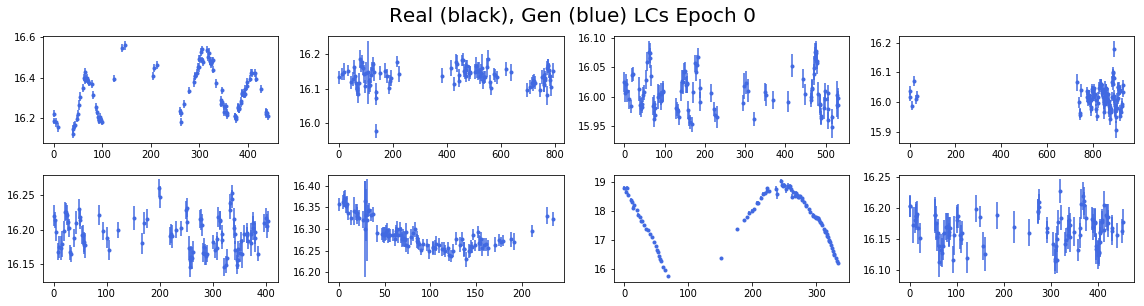

Latend space sample...


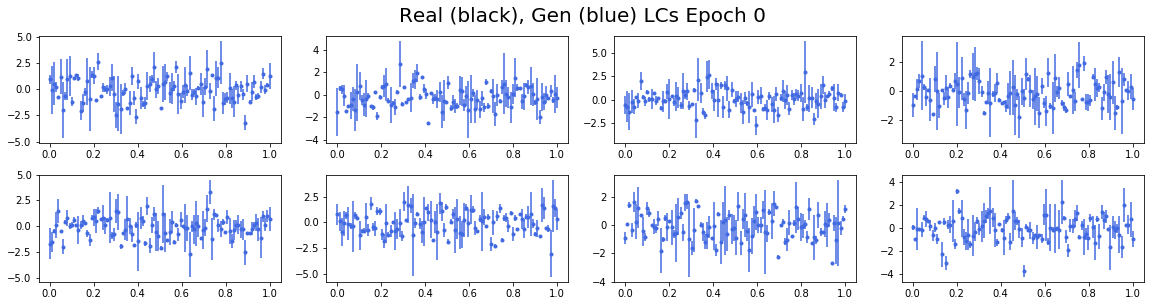

In [188]:
print('Real LC from sample...')
vis_real_idx = np.random.randint(0, len(lightcurves['vali']), size=8)
vis_real = lightcurves['vali'][vis_real_idx, :, :]
_ = plot_generated_time_series(0, vis_real, examples=8,
                               use_time=use_time,
                               use_err=use_err)
print('Latend space sample...')
vis_Z = sample_Z(batch_size, seq_length,
                 latent_dim, use_time=use_time,
                 only_one=False)
_ = plot_generated_time_series(0, vis_Z, examples=8,
                               use_time=use_time,
                               use_err=use_err)

## Train Model

Discriminator
--------------------
 hidden_units_d	:128
     seq_length	:100
     batch_size	:28
       cond_dim	:0
     num_layers	:1
        dropout	:0.2
     batch_mean	:False
     batch_norm	:True
--------------------
Generator
--------------------
 hidden_units_g	:128
     seq_length	:100
     batch_size	:28
       cond_dim	:0
     num_layers	:1
        dropout	:0.2
         n_feat	:3
--------------------
Train settings
--------------------
     batch_size	:28
       D_rounds	:3
       G_rounds	:5
       use_time	:True
     seq_length	:100
     latent_dim	:5
         n_feat	:3
       cond_dim	:0
        max_val	:1
        one_hot	:False
  learning_rate	:0.001
  smooth_labels	:False
--------------------
/Users/jorgetil/Astro/TL-GANs/logs/GAN_eros_timeT_errT/lstm_units128_drop20_nlayers1_Dr3_Gr5_smoothLF_bnT_lr1e-03/run_190326_0118


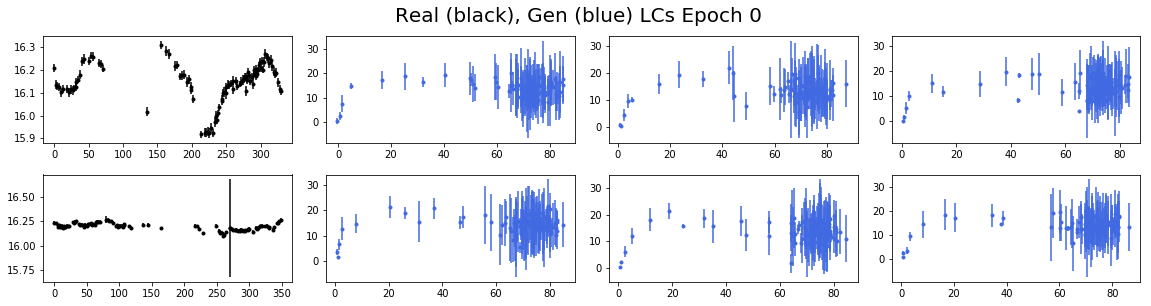

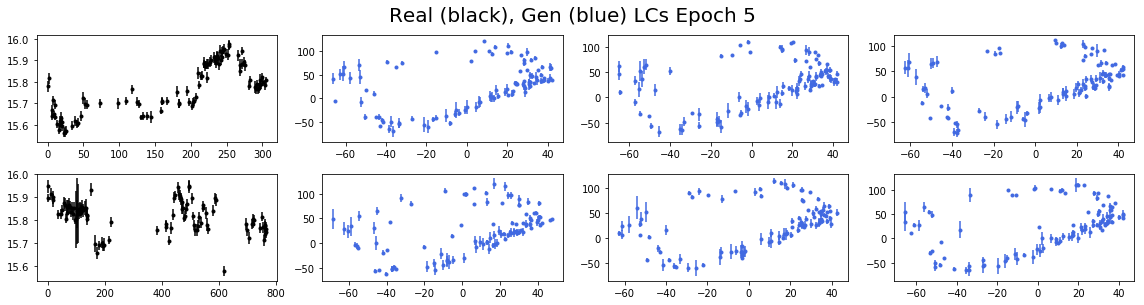

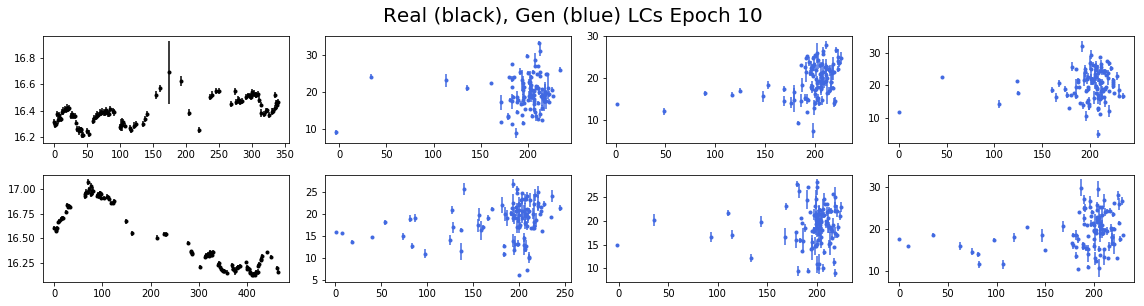

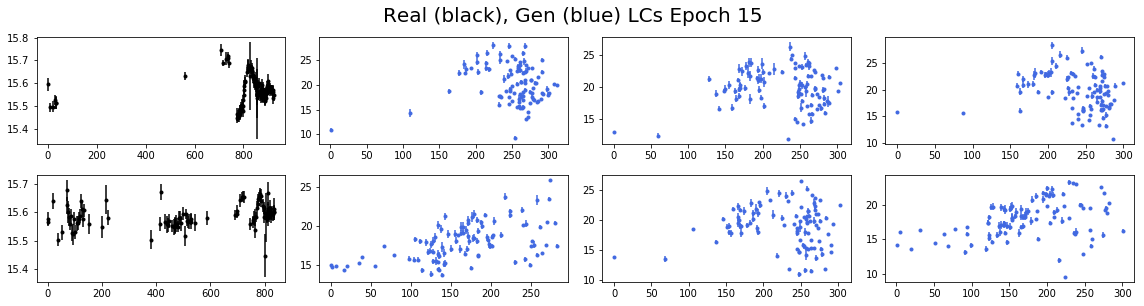

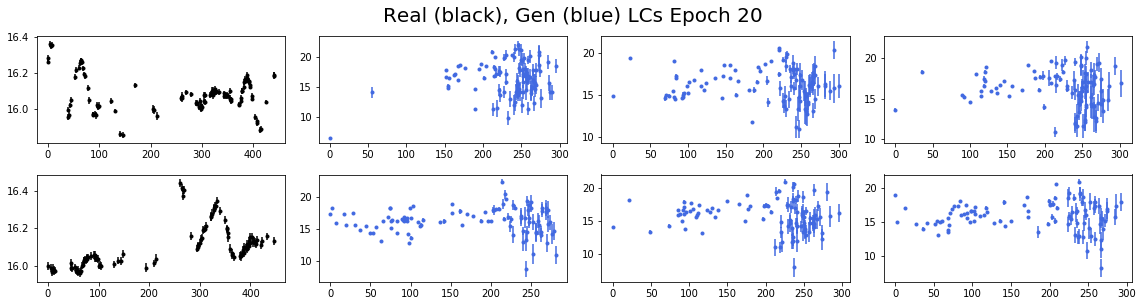

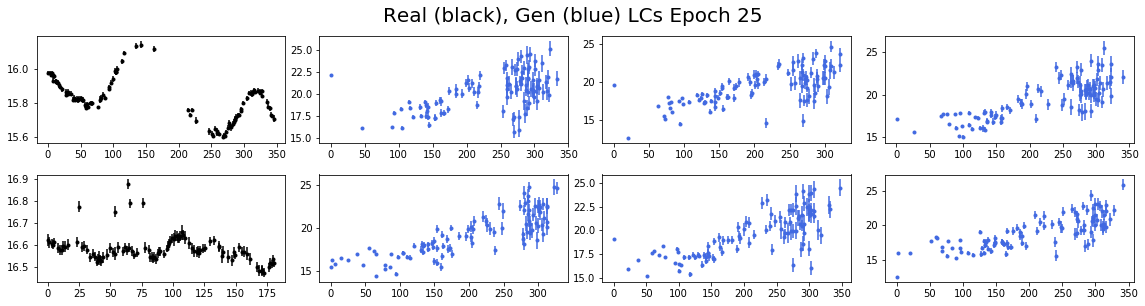

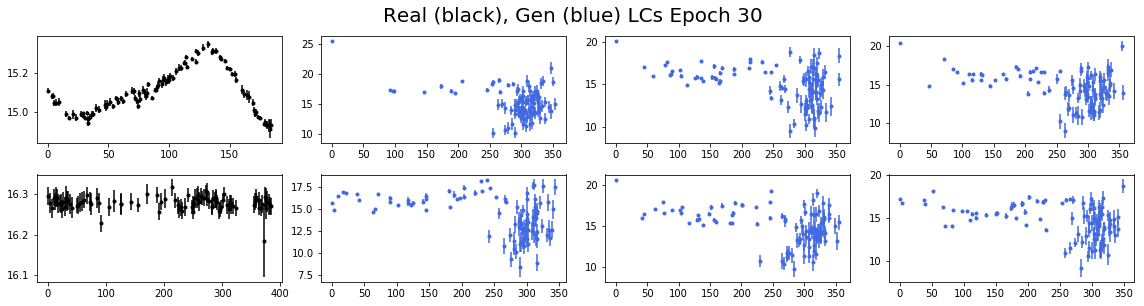

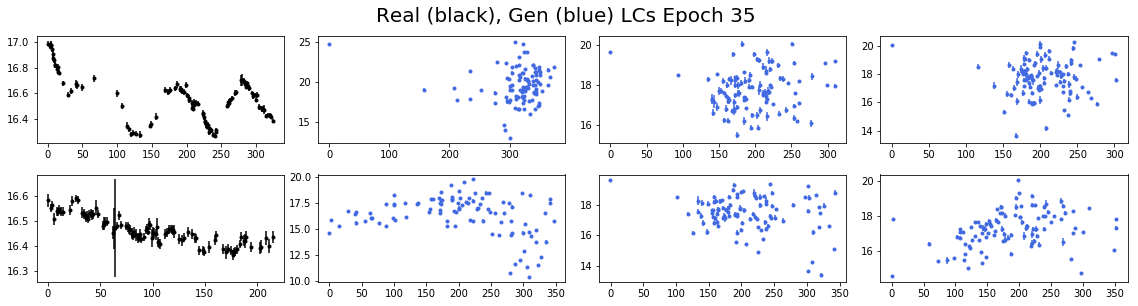

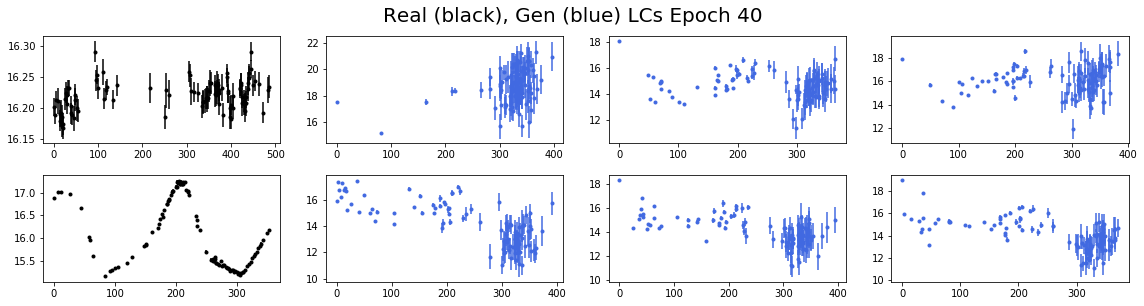

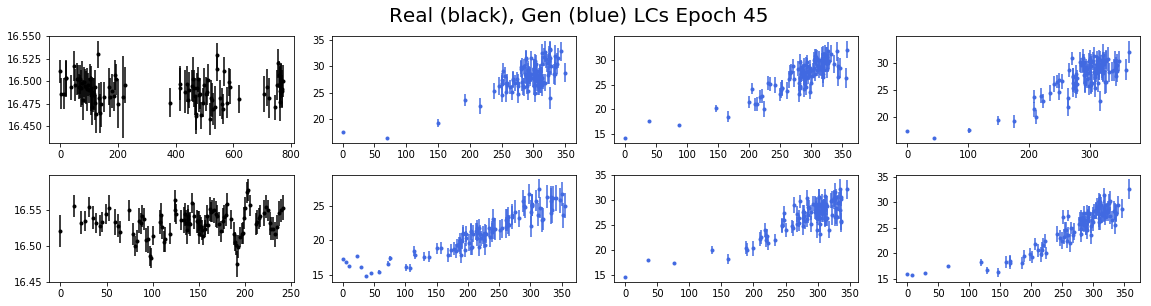

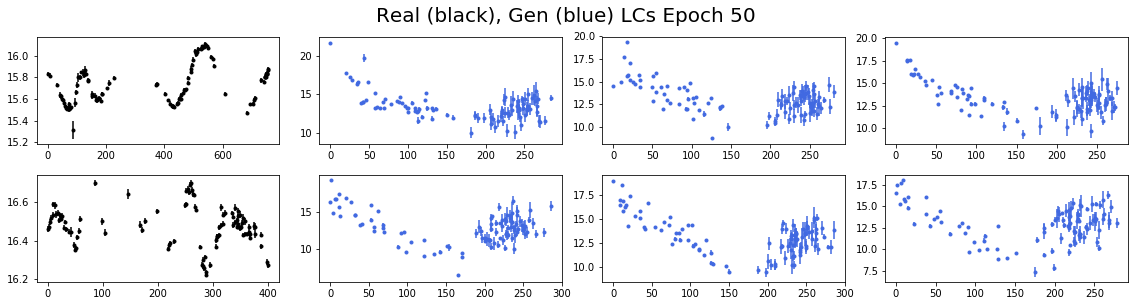

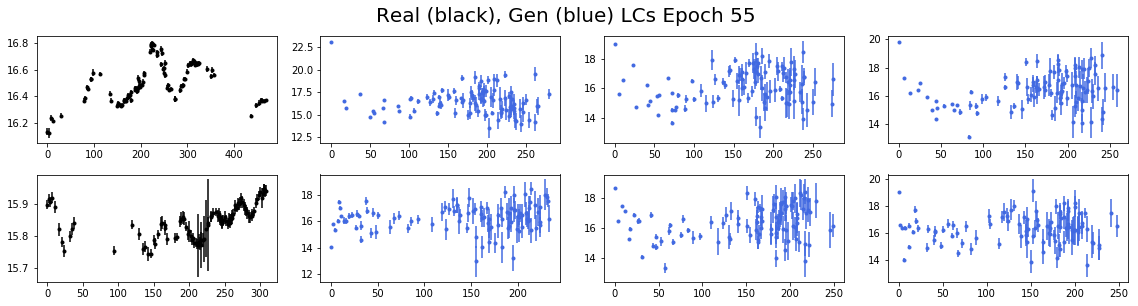

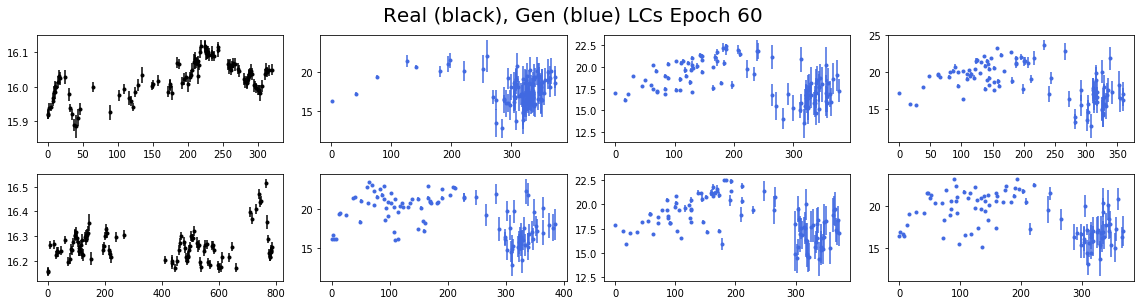

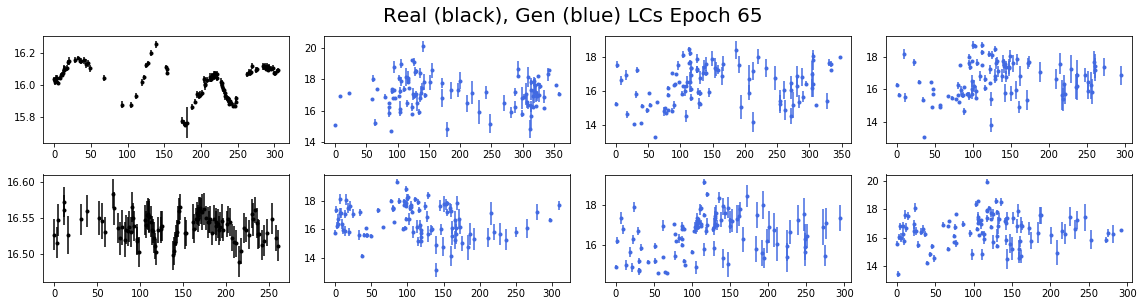

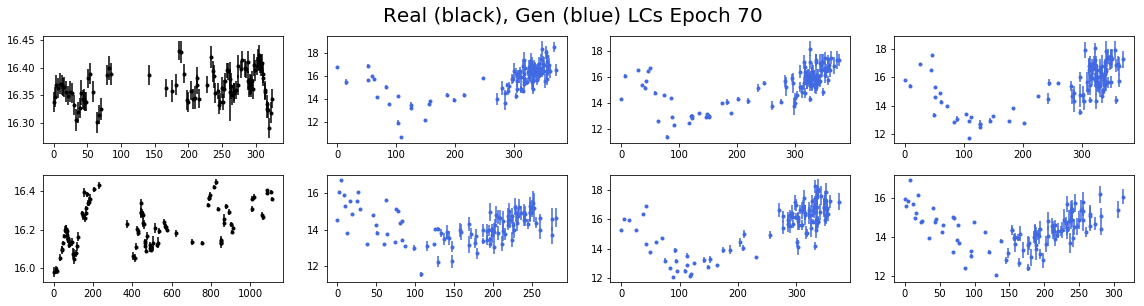

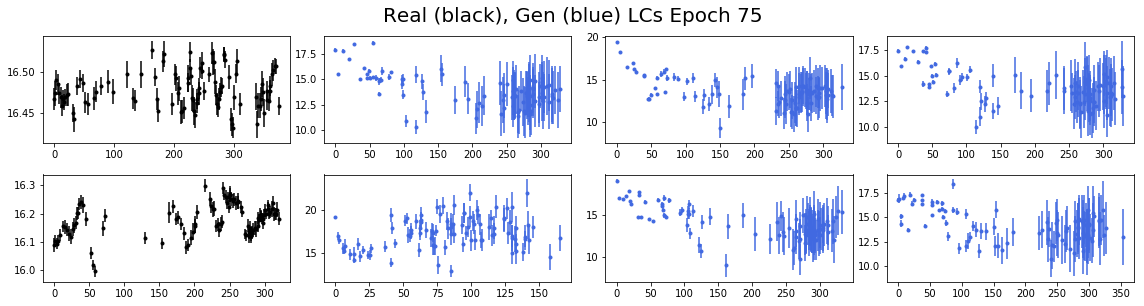

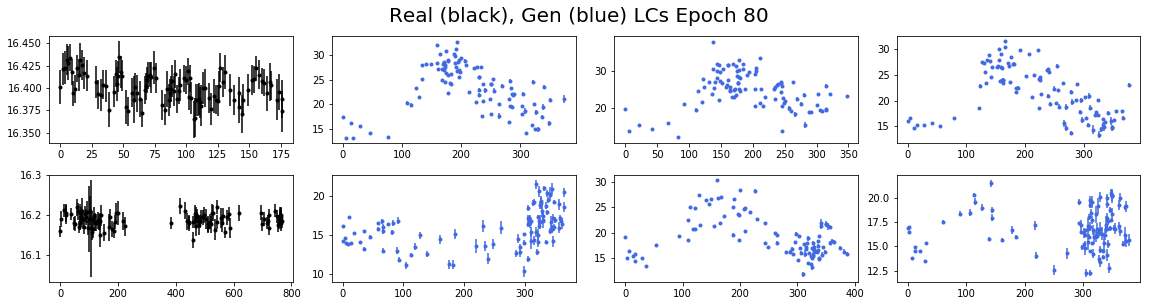

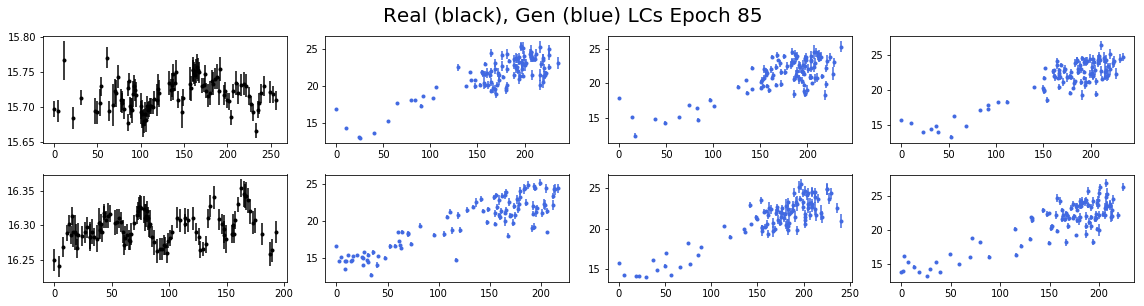

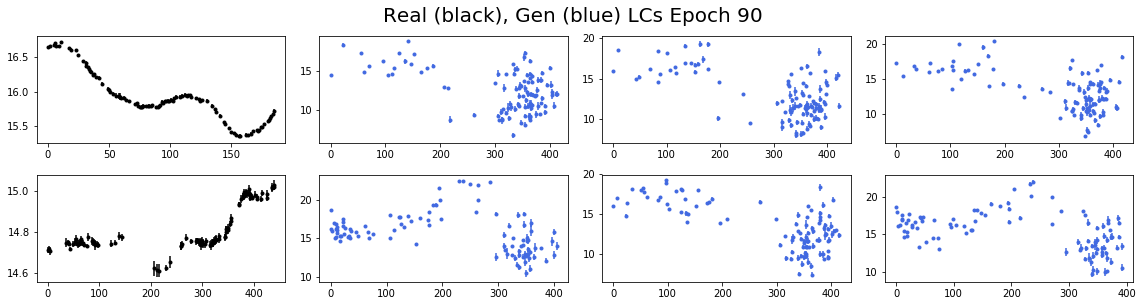

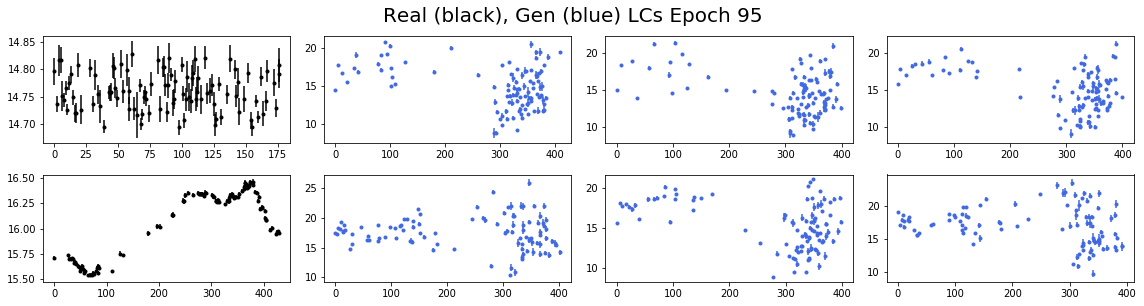

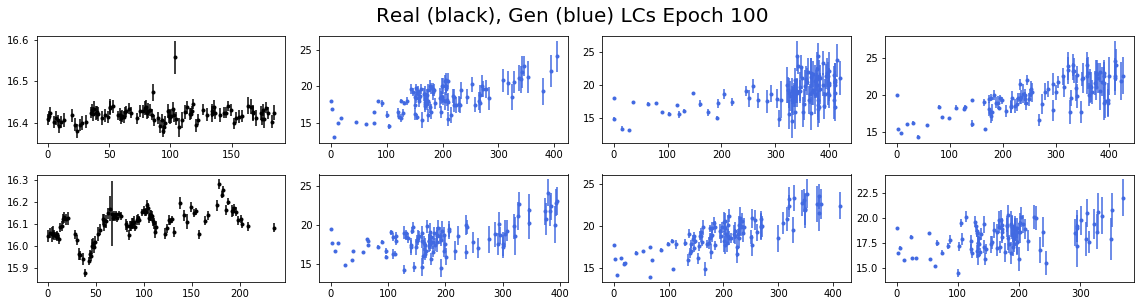

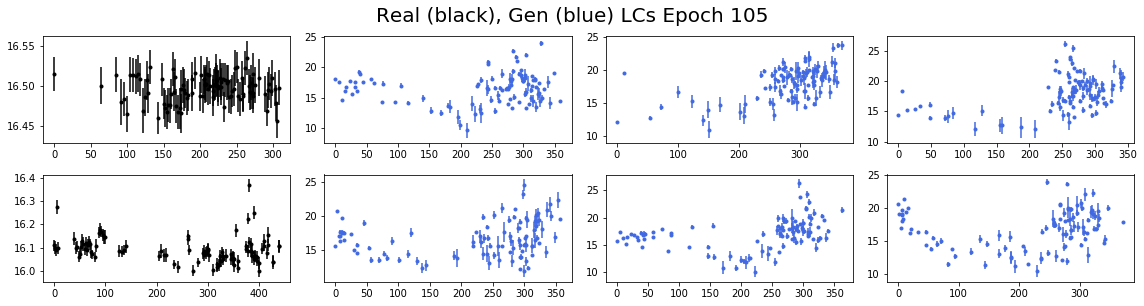

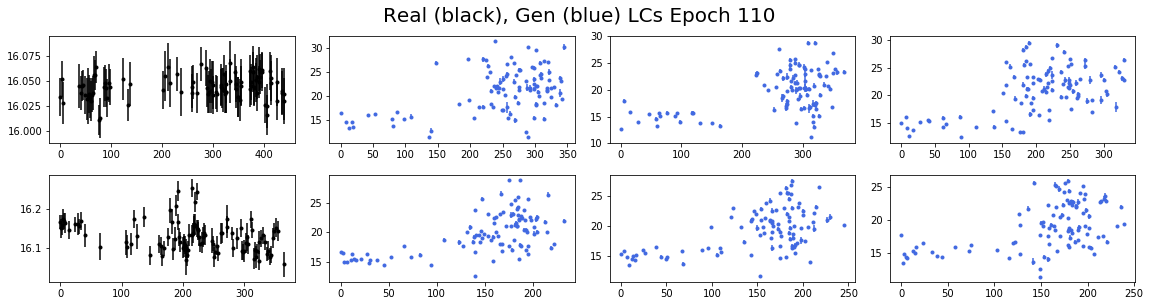

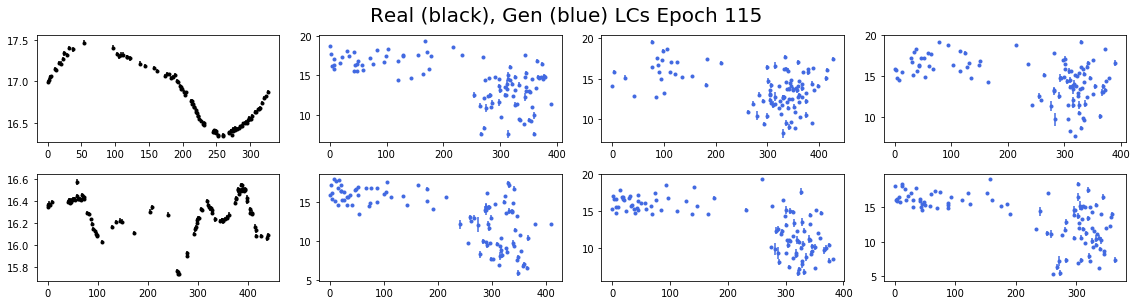

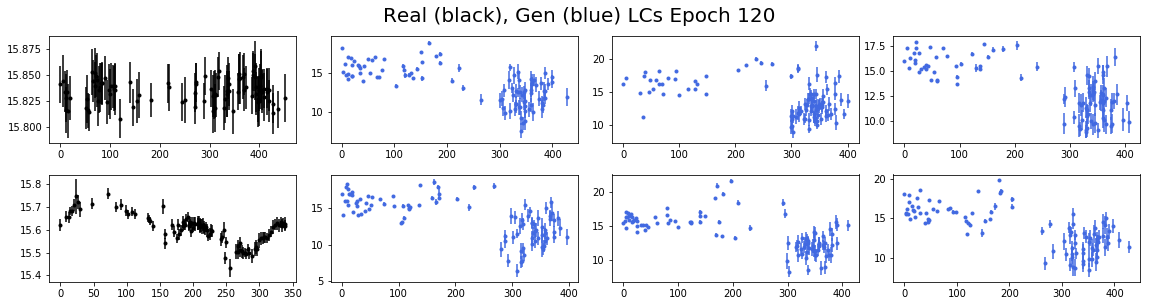

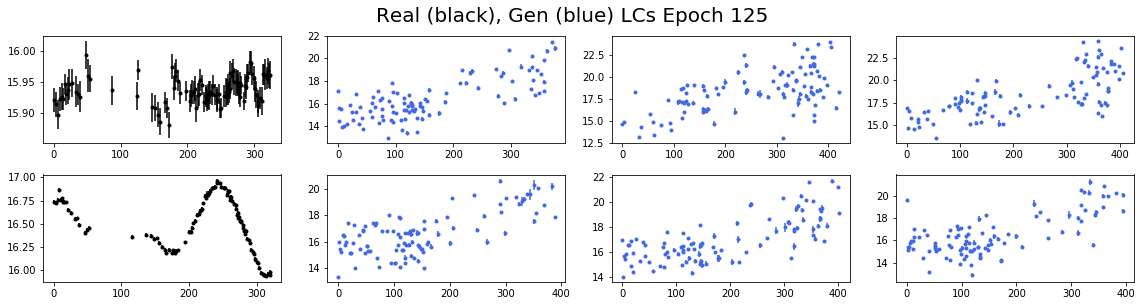

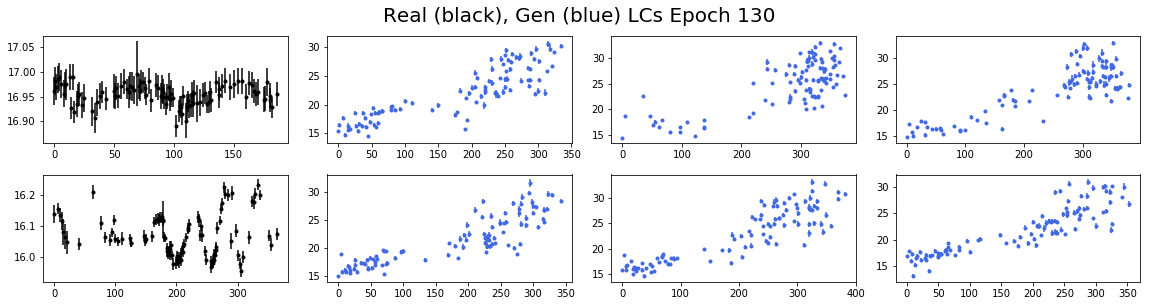

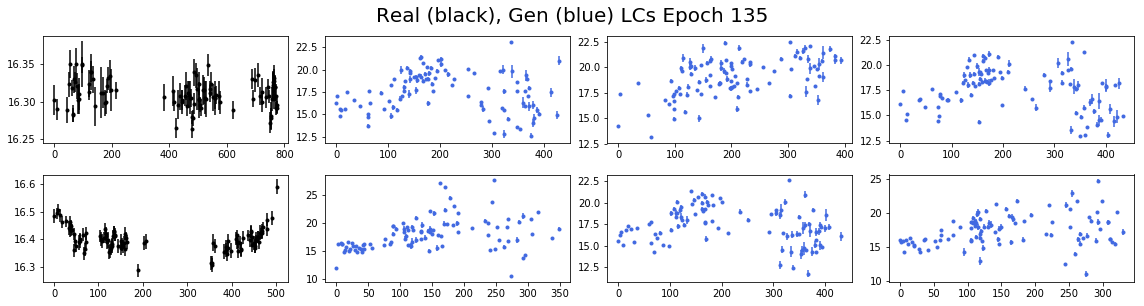

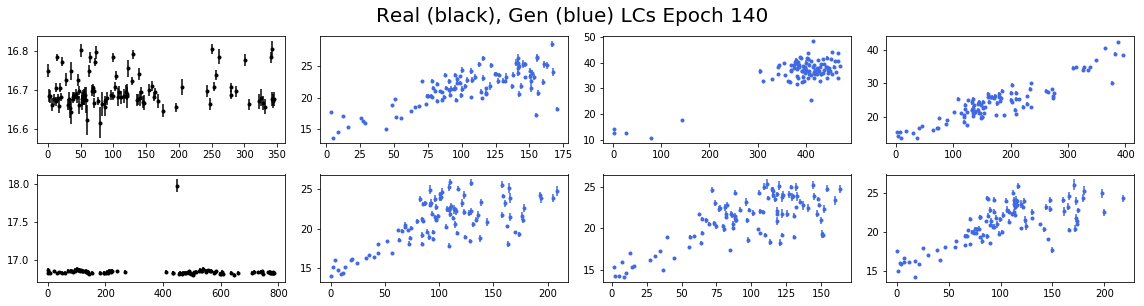

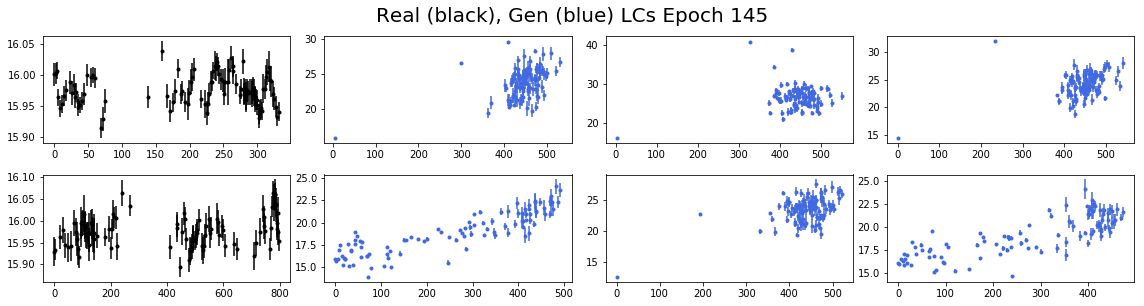

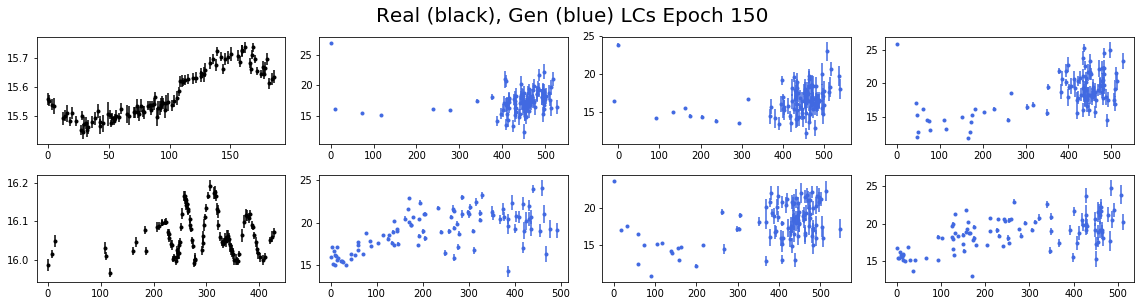

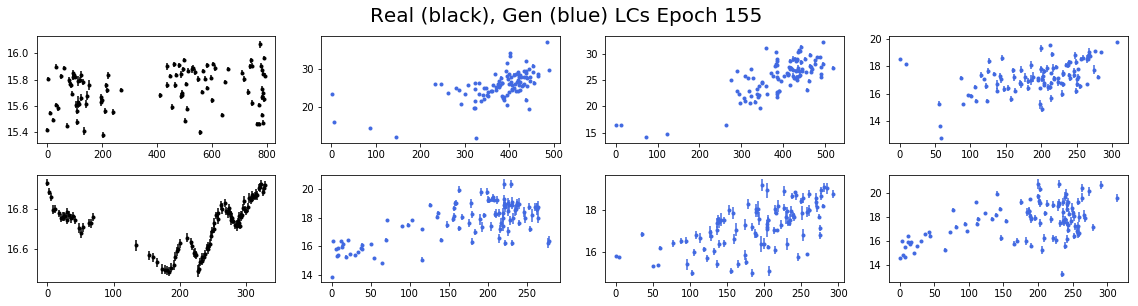

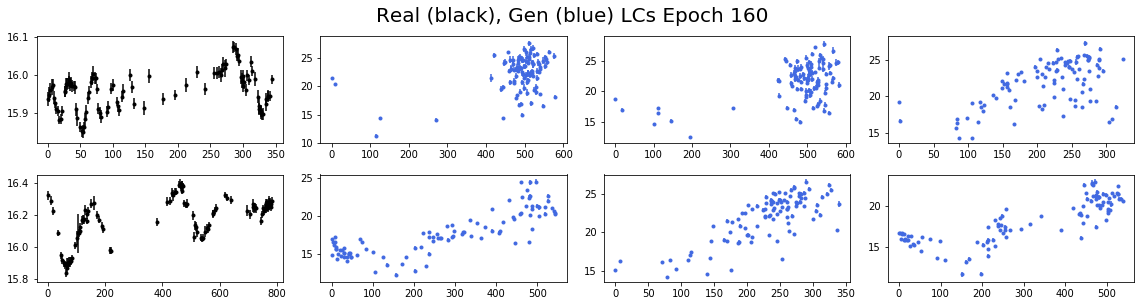

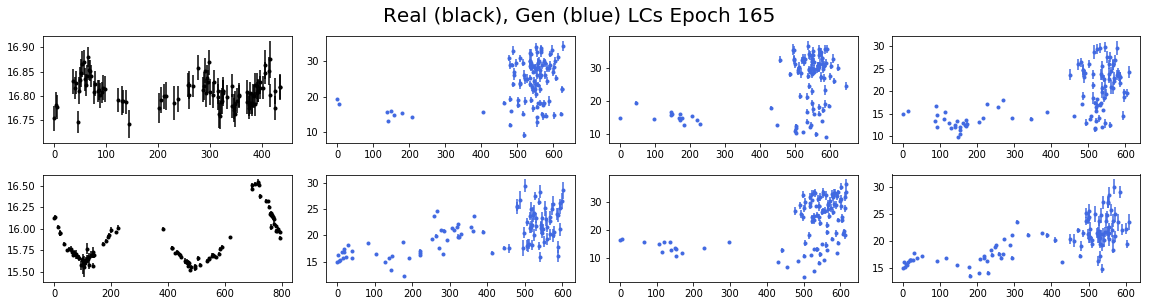

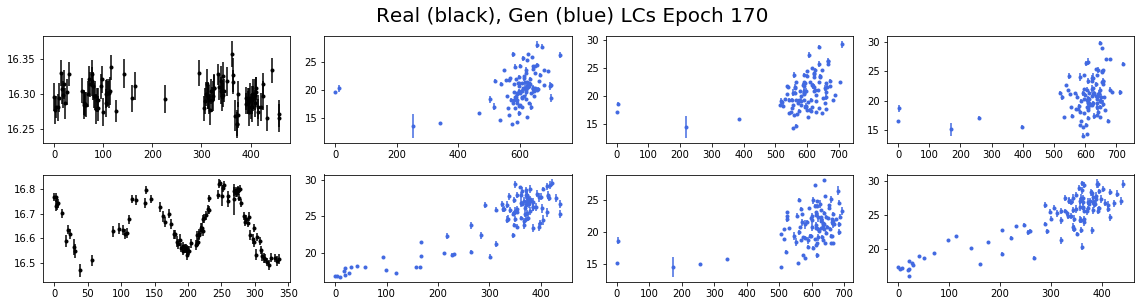

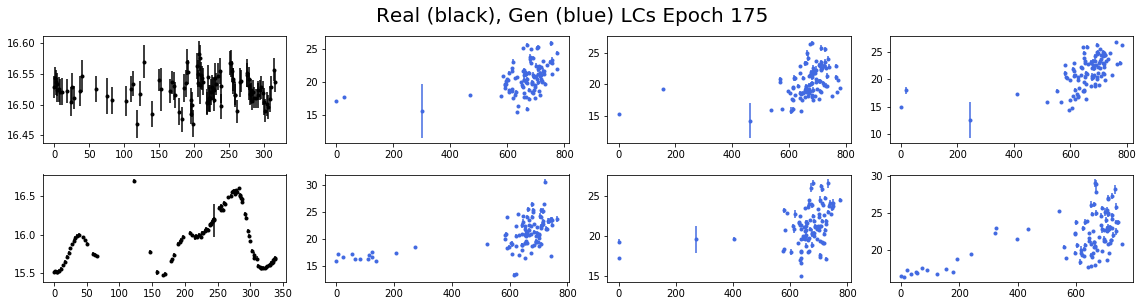

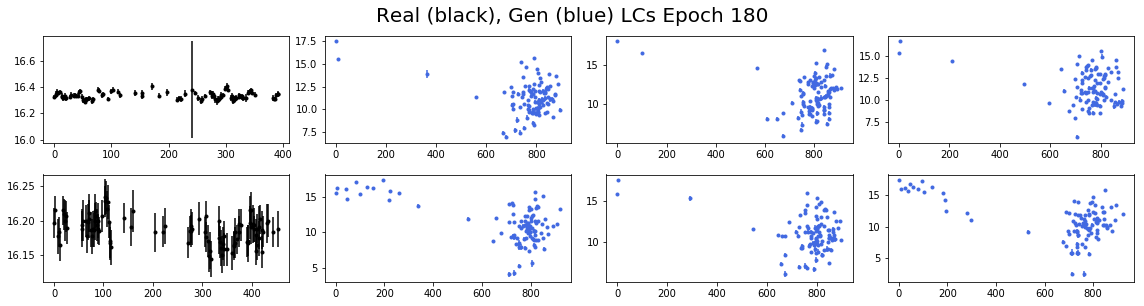

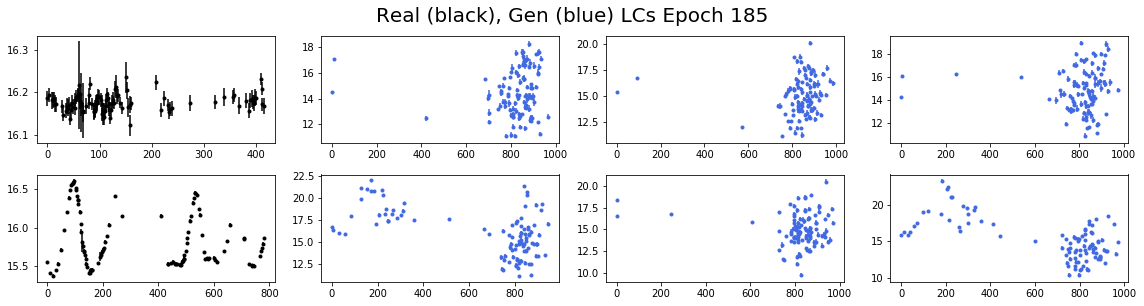

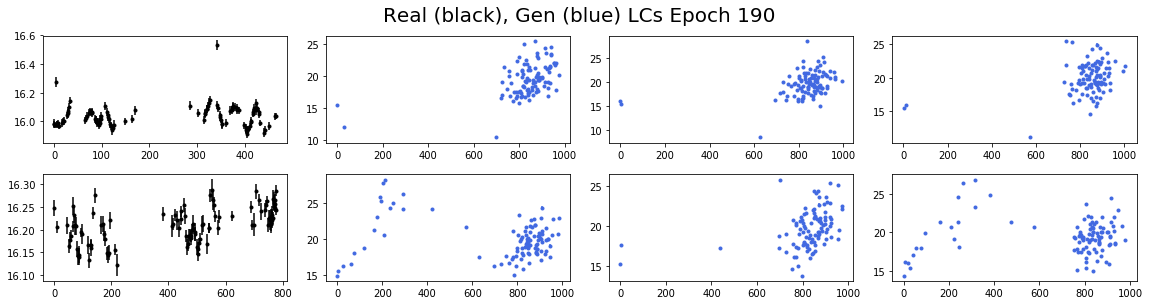

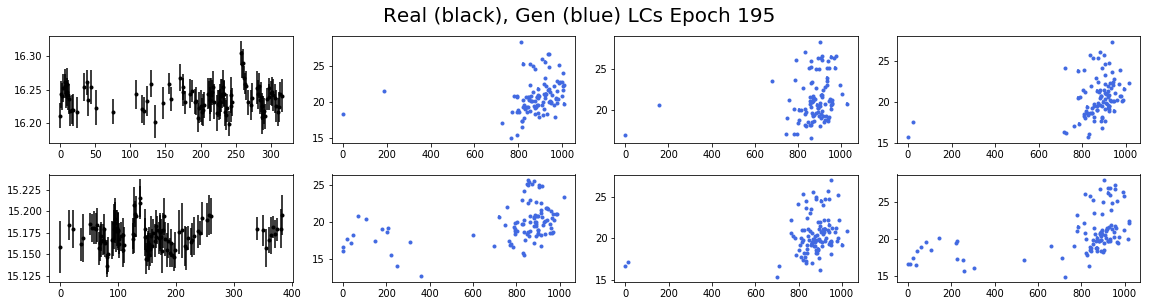

In [189]:
discriminator_vars = ['hidden_units_d', 'seq_length', 'batch_size', 
                      'cond_dim', 'num_layers', 'dropout',
                      'batch_mean', 'batch_norm']
discriminator_settings = dict((k, eval(k)) for k in discriminator_vars)
generator_vars = ['hidden_units_g', 'seq_length', 'batch_size',
                  'cond_dim', 'num_layers', 'dropout',
                  'n_feat']
generator_settings = dict((k, eval(k)) for k in generator_vars)

print('Discriminator')
print('--------------------')
for key, value in discriminator_settings.items():
    print('%15s\t:%s' % (key, value))
print('--------------------')
print('Generator')
print('--------------------')
for key, value in generator_settings.items():
    print('%15s\t:%s' % (key, value))
print('--------------------')
print('Train settings')
print('--------------------')
for key, value in train_settings.items():
    print('%15s\t:%s' % (key, value))
print('--------------------')
log_dir = ('%s/logs/%s/%s_units%i_drop%i_nlayers%i_Dr%i_Gr%i_smoothL%s_bn%s_lr%.0e/run_%s' % 
           (main_path, model_name, 'lstm', hidden_units_d,
            int(dropout*100), num_layers, D_rounds, G_rounds,
            str(smooth_labels)[0], str(batch_norm)[0],
            learning_rate,
            datetime.datetime.now().strftime("%y%m%d_%I%M")))
print(log_dir)

tf.reset_default_graph()
Z, X, CG, CD, CS = create_placeholders(batch_size,
                                       seq_length,
                                       latent_dim,
                                       n_feat,
                                       cond_dim)

CGAN = (cond_dim > 0)

D_loss, G_loss, D_acc = GAN_loss(Z, X, generator_settings, 
                                  discriminator_settings,
                                  CGAN, CG, CD, CS, 
                                  smooth_labels=smooth_labels,
                                  wrong_labels=wrong_labels)
D_solver, G_solver = GAN_solvers(D_loss, G_loss,
                                 learning_rate)
with tf.name_scope('Vizualization'):
    G_sample = generator(Z, **generator_settings, reuse=True, c=CG)

###########################################################################

# initialize tensorflow session
sess = tf.Session()
tf.summary.scalar('D_loss', D_loss)
tf.summary.scalar('G_loss', G_loss)
tf.summary.scalar('D_acc', D_acc)
merged_summary = tf.summary.merge_all()
sess.run(tf.global_variables_initializer())
summary_writer = tf.summary.FileWriter(log_dir, sess.graph)

###########################################################################

for epoch in range(num_epochs):
    samples = lightcurves['train']
    ## train in batches...
    for batch_idx in tnrange(0, int(len(samples) / batch_size) -
                             (D_rounds + (cond_dim > 0)*G_rounds),
                             D_rounds + (cond_dim > 0)*G_rounds,
                             desc='Epoch: %i' % (epoch), leave=False):
        ## update the discriminator
        iteration = epoch * int(len(samples) / batch_size) + batch_idx
        for d in range(D_rounds):

            X_mb, Y_mb = get_batch(samples, batch_size, 
                                   batch_idx + d, labels['train'])
            Z_mb = sample_Z(batch_size, seq_length, latent_dim, 
                            use_time=use_time, only_one=False)
            if cond_dim > 0:
                # CGAN
                Y_mb = Y_mb.reshape(-1, cond_dim)
                if one_hot:
                    # change all of the labels to a different one
                    offsets = np.random.choice(cond_dim-1, batch_size) + 1
                    new_labels = (np.argmax(Y_mb, axis=1) + offsets) % cond_dim
                    Y_wrong = np.zeros_like(Y_mb)
                    Y_wrong[np.arange(batch_size), new_labels] = 1
                else:
                    # flip all of the bits (assuming binary...)
                    Y_wrong = 1 - Y_mb
                _ = sess.run(D_solver, feed_dict={X: X_mb, Z: Z_mb,
                                                  CD: Y_mb, CS: Y_wrong,
                                                  CG: Y_mb})
            else:
                _ = sess.run(D_solver, feed_dict={X: X_mb, Z: Z_mb})

        ## update the generator
        for g in range(G_rounds):
            if cond_dim > 0:
                # note we are essentially throwing these X_mb away...
                X_mb, Y_mb = get_batch(samples, batch_size,
                                       batch_idx + D_rounds + g,
                                       labels['train'])
                _ = sess.run(G_solver,
                             feed_dict={Z: sample_Z(batch_size, seq_length,
                                                    latent_dim,
                                                    use_time=use_time,
                                                    only_one=False),
                                        CG: Y_mb})
            else:
                _ = sess.run(G_solver,
                             feed_dict={Z: sample_Z(batch_size, seq_length,
                                                    latent_dim,
                                                    use_time=use_time,
                                                    only_one=False)})
        ## Get Loss values at the end of 50 batch
        if iteration % 50 == 0:
            if cond_dim > 0:
                summary_val = sess.run(merged_summary,
                                       feed_dict={X: X_mb,
                                                  Z: sample_Z(batch_size,
                                                              seq_length,
                                                              latent_dim,
                                                              use_time=use_time,
                                                              only_one=False),
                                                  CG: Y_mb, CD: Y_mb})
            else:
                summary_val = sess.run(merged_summary,
                                       feed_dict={X: X_mb,
                                                  Z: sample_Z(batch_size,
                                                              seq_length,
                                                              latent_dim,
                                                              use_time=use_time,
                                                              only_one=False)})
            summary_writer.add_summary(summary_val, iteration)

    ## visualise plots of generated samples, with/without labels
    if epoch % 5 == 0 or epoch == 0:
        if CGAN:
            vis_C = sample_C(batch_size, cond_dim, max_val, one_hot)
            vis_sample = sess.run(G_sample, feed_dict={Z: vis_Z, CG: vis_C})
        else:
            vis_sample = sess.run(G_sample, feed_dict={Z: vis_Z})
        idx_vali = np.random.choice(len(lightcurves['vali']), size=8)
        img_buf = plot_generated_time_series(epoch, vis_sample,
                                             test_lc=lightcurves['vali'][idx_vali],
                                             use_time=use_time,
                                             use_err=use_err)
        image = tf.image.decode_png(img_buf.getvalue(), channels=4)
        image = tf.expand_dims(image, 0)
        summary_ima = tf.summary.image("Gen_lcs", image, max_outputs=1)
        summary_writer.add_summary(summary_ima.eval(session=sess),
                                   iteration)

    ## shuffle the training data
    if shuffle:     
        perm = np.random.permutation(lightcurves['train'].shape[0])
        lightcurves['train'] = lightcurves['train'][perm]
        if labels['train'] is not None:
            labels['train'] = labels['train'][perm]